<a href="https://colab.research.google.com/github/voirinprof/python-geo-colab/blob/main/Int%C3%A9grer_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutoriel : Intégrer scikit-learn avec Google Earth Engine et Google Colab


### Objectif

1. Configurer notre environnement.
2. Charger une image satellite avec GEE.
3. Utiliser `scikit-learn` pour analyser l'image
4. Visualiser les résultats sur une carte interactive.


Prérequis : Un compte Google (pour Colab, GEE et Google Drive).

## Installer GEE et scikit-learn dans Colab

In [1]:
# Installer et configurer GEE et scikit-learn
!pip install earthengine-api scikit-learn

## Importer les libs utiles

In [2]:
# Importer les bibliothèques
import ee
import geemap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Se connecter à GEE

In [3]:

# Authentification (exécutez cette cellule et suivez les instructions)
ee.Authenticate()  # Ouvre une fenêtre pour se connecter à votre compte Google
ee.Initialize(project="gmq580")  # Initialise GEE avec vos identifiants

# il peut être nécessaire de créer un projet dans Google Cloud Console

print("GEE est prêt à être utilisé !")

GEE est prêt à être utilisé !


## Débuter votre analyse

Définir une zone d’intérêt

In [4]:
# On va utiliser la localisation de Sherbrooke
region = ee.Geometry.Point([-71.888351, 45.404476])  # Centre sur Sherbrooke
area = region.buffer(10000)  # Crée une zone tampon de 10 km autour du point

Charger les données

In [5]:
# Charger une image Sentinel-2 (médiane sur l'été 2023)
sentinel = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(area) \
            .filterDate('2023-06-01', '2023-08-31') \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
            .median()

# Sélectionner les bandes spectrales et calculer le NDVI
bands = sentinel.select(['B2', 'B3', 'B4', 'B8'])  # Bleu, Vert, Rouge, NIR
ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')
image = bands.addBands(ndvi)  # Image avec bandes et NDVI

Créer des données d’entraînement

In [13]:
# Charger le fichier CSV
samples_df = pd.read_csv('/content/samples.csv')

# Créer une liste de points d'entraînement
training_points = []
for index, row in samples_df.iterrows():
  point = ee.Feature(ee.Geometry.Point([row['longitude'], row['latitude']]), {'pixel_value': row['pixel_value']})
  training_points.append(point)

# Créer une FeatureCollection à partir de la liste de points
training_fc = ee.FeatureCollection(training_points)

# Échantillonner l'image aux points d'entraînement
training_data = image.sampleRegions(
    collection=training_fc,
    properties=['pixel_value'],
    scale=10
)

# Convertir en DataFrame pandas
data = training_data.getInfo()['features']
df = pd.DataFrame([f['properties'] for f in data])

print("Données d'entraînement :")
print(df.head())

Données d'entraînement :
       B2      B3     B4      B8      NDVI  pixel_value
0  1124.0  1070.0  869.0  3052.0  0.556746           15
1  1071.5   957.0  690.0  2788.0  0.603220           17
2  1087.0   984.0  717.0  2750.0  0.586386           17
3  1002.0   906.0  554.0  3027.0  0.690589            6
4   843.0   731.0  392.0  3684.5  0.807678            5


Entraîner un modèle Random Forest avec scikit-learn

In [14]:
# Séparer les caractéristiques (X) et la cible (y)
X = df[['B2', 'B3', 'B4', 'B8', 'NDVI']]
y = df['pixel_value']

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer et entraîner le modèle Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Évaluer la précision sur l'ensemble de test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")

Précision du modèle : 0.66


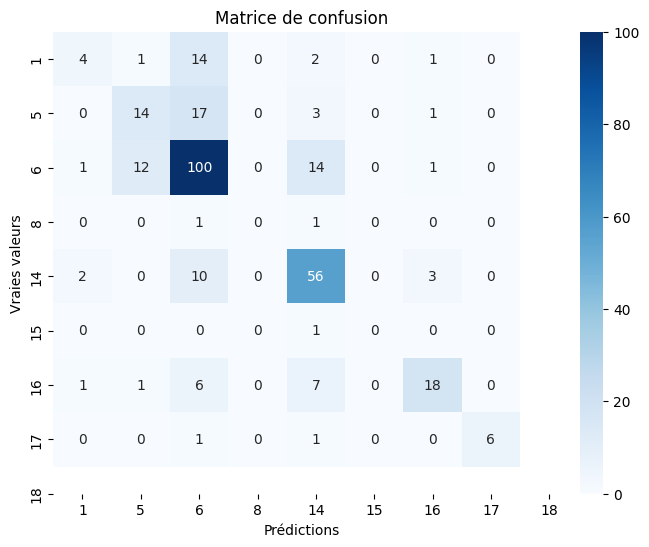

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()


Appliquer le modèle à l’image entière

In [25]:
# Préparer l'image pour la prédiction (convertir en tableau numpy)
image_array = image.toArray()
image_flat = image_array.arrayFlatten([['B2', 'B3', 'B4', 'B8', 'NDVI']])

# Échantillonner l'image pour prédiction (limité pour la démonstration)
sample = image_flat.sample(region=area, scale=10, numPixels=4000)
sample_data = sample.getInfo()['features']
df_sample = pd.DataFrame([f['properties'] for f in sample_data])

# Prédire les classes avec scikit-learn
X_sample = df_sample[['B2', 'B3', 'B4', 'B8', 'NDVI']]
predictions = model.predict(X_sample)

# Ajouter les prédictions au DataFrame
df_sample['predicted_class'] = predictions

Visualiser les prédictions sur une carte

In [20]:
df_sample.head()

,B2,B3,B4,B8,NDVI,predicted_class
0,1091.0,981.0,629.0,2949.0,0.648407,1
1,1063.0,897.0,555.0,3827.0,0.746691,6
2,1036.0,883.0,543.0,3168.0,0.707357,6
3,972.0,842.0,454.0,2667.0,0.709068,6
4,992.0,840.0,516.0,2688.0,0.677903,6


Sauvegarder le modèle entrainé dans un fichier

In [29]:
import pickle

# Sauvegarder le modèle entraîné dans un fichier
filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb'))

print(f"Modèle enregistré dans {filename}")


Modèle enregistré dans trained_model.sav


Exporter l’image depuis GEE

In [35]:
# Exporter l'image vers Google Drive
export_params = {
    'image': image.float(),
    'description': 'Sentinel_sherbrooke_summer_2023',
    'folder': 'GEE_Exports',
    'scale': 10,
    'region': area,  # Zone plus grande
    'maxPixels': 1e9
}

task = ee.batch.Export.image.toDrive(**export_params)
task.start()

print("Exportation lancée ! Une fois terminée, téléchargez le fichier depuis Drive.")

Exportation lancée ! Une fois terminée, téléchargez le fichier depuis Drive.


In [38]:
# Vérifier l'état de la tâche
import time

# Boucle pour vérifier l'état toutes les 10 secondes
for _ in range(10):  # Vérifie pendant 100 secondes max
    status = task.status()['state']
    print(f"État de l'exportation : {status}")
    if status in ['COMPLETED', 'FAILED']:
        break
    time.sleep(10)

if status == 'COMPLETED':
    print("Exportation terminée ! Fichier disponible dans Google Drive.")
elif status == 'FAILED':
    print("Erreur lors de l'exportation. Vérifiez les paramètres.")
else:
    print("L'exportation est en cours. Cela peut prendre plus de temps.")

État de l'exportation : RUNNING
État de l'exportation : RUNNING
État de l'exportation : RUNNING
État de l'exportation : RUNNING
État de l'exportation : RUNNING
État de l'exportation : COMPLETED
Exportation terminée ! Fichier disponible dans Google Drive.


Installer rasterio

In [30]:
# Installer rasterio pour lire le GeoTIFF
!pip install rasterio

In [39]:
# prompt: recharger le modèle sauvée pour l'appliquer à une image

import pickle
import rasterio
import numpy as np

# Charger le modèle entraîné à partir du fichier
filename = 'trained_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

# Charger l'image téléchargée (remplacez par le chemin de votre image)
image_path = '/content/drive/MyDrive/GEE_exports/Sentinel_sherbrooke_summer_2023.tif'

with rasterio.open(image_path) as src:
    image_data = src.read()
    profile = src.profile

# Prétraiter l'image (si nécessaire, adaptez selon votre prétraitement)
# Par exemple, reshape l'image en un tableau 2D de pixels
bands = image_data.shape[0]
height = image_data.shape[1]
width = image_data.shape[2]

image_array = image_data.reshape(bands, height * width).transpose()

# Prédire les classes avec le modèle chargé
predictions = loaded_model.predict(image_array)

# Convertir les prédictions en une image raster
prediction_image = predictions.reshape(height, width)


# Enregistrer les prédictions en tant qu'image GeoTIFF
with rasterio.open('predictions.tif', 'w', **profile) as dst:
    dst.write(prediction_image.astype(rasterio.uint8), 1)


print("Prédictions enregistrées dans predictions.tif")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Prédictions enregistrées dans predictions.tif


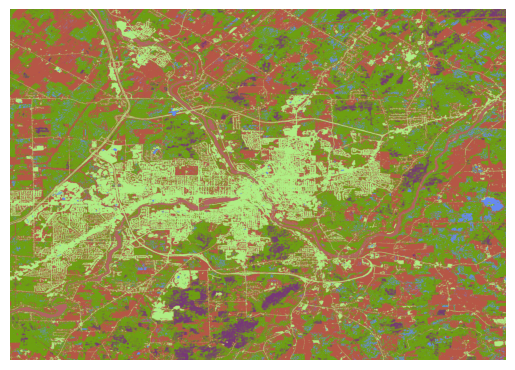

In [43]:
# prompt: lire une image classifiée et attribuer des couleurs aléatoires et afficher avec matplotlib

import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Charger l'image de prédictions
with rasterio.open('/content/predictions.tif') as src:
    prediction_data = src.read(1).astype(np.uint8)


# Créer un tableau de couleurs aléatoires
num_classes = 20
colors = np.random.randint(0, 256, size=(num_classes, 3))

# Créer une image colorée en fonction des classes
colored_image = np.zeros((prediction_data.shape[0], prediction_data.shape[1], 3), dtype=np.uint8)
for class_id in np.unique(prediction_data):
    colored_image[prediction_data == class_id] = colors[class_id]

# Afficher l'image colorée avec Matplotlib
plt.imshow(colored_image)
plt.axis('off')
plt.show()
